In [1]:
import torch
import torchvision
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = torch.device("cuda")

In [3]:
from constant import CONFIG

CONFIG

SAMConfig(sam2_checkpoint='../sam2/checkpoints/sam2.1_hiera_large.pt', model_cfg='../sam2/configs/sam2.1/sam2.1_hiera_l.yaml')

In [4]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = CONFIG.sam2_checkpoint
model_cfg = CONFIG.model_cfg

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [6]:
import cv2
import os
from pathlib import Path
from utils.split_video import split_video


# Path to the video file
video_path = Path(r"C:\Users\AORUS\Desktop\program\gif_generator\assests\videoplayback.mp4")
split_video(video_path)



Frames extracted and saved to temp\test


In [6]:
from constant import SPLIT_OUTPUT
inference_state = predictor.init_state(video_path=SPLIT_OUTPUT)

frame loading (JPEG): 100%|██████████| 51/51 [00:01<00:00, 28.16it/s]


In [7]:
predictor.reset_state(inference_state)

In [8]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[210, 350]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)


C:\Users\AORUS\Desktop\program\gif_generator\sam2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:773.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
C:\Users\AORUS\Desktop\program\gif_generator\sam2\sam2\modeling\sam\transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen/native/transformers/sdp_utils_cpp.h:558.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
C:\Users\AORUS\Desktop\program\gif_generator\sam2\sam2\modeling\sam\transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\s

In [9]:
from utils.segement import video_segement, show_segment

video_segements = video_segement(predictor=predictor, inference_state=inference_state)

propagate in video: 100%|██████████| 51/51 [00:29<00:00,  1.76it/s]


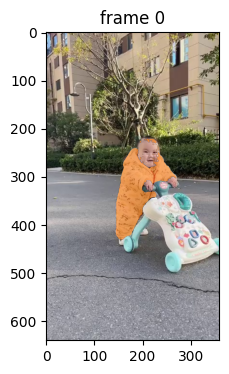

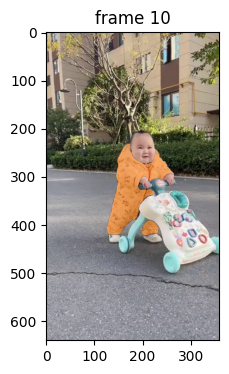

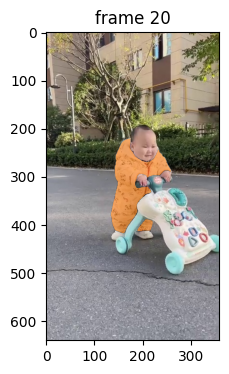

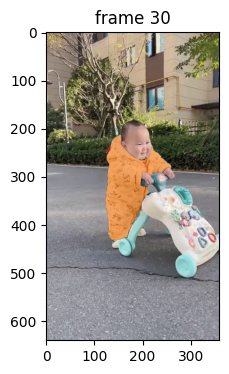

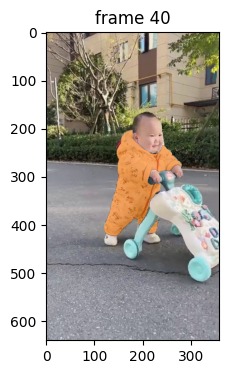

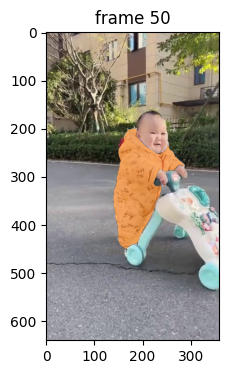

In [10]:
# render the segmentation results every few frames
vis_frame_stride = 10
plt.close("all")
for out_frame_idx in range(0, 51, vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}") 
    plt.imshow(Image.open(os.path.join(SPLIT_OUTPUT, f"{out_frame_idx:04d}.jpg")))
    for out_obj_id, out_mask in video_segements[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

In [ ]:
from utils.crop_img import crop_mask

crop_mask(video_segments=video_segements, frame_len=51)

Saved 0000_masked.png as PNG
Saved 0001_masked.png as PNG
Saved 0002_masked.png as PNG
Saved 0003_masked.png as PNG
Saved 0004_masked.png as PNG
Saved 0005_masked.png as PNG
Saved 0006_masked.png as PNG
Saved 0007_masked.png as PNG
Saved 0008_masked.png as PNG
Saved 0009_masked.png as PNG
Saved 0010_masked.png as PNG
Saved 0011_masked.png as PNG
Saved 0012_masked.png as PNG
Saved 0013_masked.png as PNG
Saved 0014_masked.png as PNG
Saved 0015_masked.png as PNG
Saved 0016_masked.png as PNG
Saved 0017_masked.png as PNG
Saved 0018_masked.png as PNG
Saved 0019_masked.png as PNG
Saved 0020_masked.png as PNG
Saved 0021_masked.png as PNG
Saved 0022_masked.png as PNG
Saved 0023_masked.png as PNG
Saved 0024_masked.png as PNG
Saved 0025_masked.png as PNG
Saved 0026_masked.png as PNG
Saved 0027_masked.png as PNG
Saved 0028_masked.png as PNG
Saved 0029_masked.png as PNG
Saved 0030_masked.png as PNG
Saved 0031_masked.png as PNG
Saved 0032_masked.png as PNG
Saved 0033_masked.png as PNG
Saved 0034_mas

In [2]:
from utils.to_gif import to_gif

to_gif(51,0.01)

GIF saved as 'temp\gif\output.gif'
